## Setup

In [1]:
from environment import LossGame1DEnv
from solver import VanillaGradientUpdate, LocalMinimaxUpdate
import torch as t
import numpy as np
from tqdm import tqdm
from mcts import MCTS
from spaces import BoxActionSpace

from matplotlib import pyplot as plt

To update: comparing the effectiveness of MCTS with or without local updates. What are the local updates? Do we use `LocalMinimax`?

## Monte Carlo Tree Search

In [2]:
# gradually increase the budget of MCTS
env = LossGame1DEnv(num_stages=3, num_players=3, d_action=1)
num_sims = np.linspace(100, 5000, 20)

# pbar = tqdm(total=np.sum(num_sims))
all_actions = []
all_payoffs = []
for num_sim in tqdm(num_sims):
    mcts = MCTS(env, action_space=BoxActionSpace(d_action=1, lows=[-5.0], highs=[5.0]), num_simulations=int(num_sim))
    actions = []
    root = env

    for _ in range(env.num_stages):
        mcts.run()
        abstract_action, action = mcts.select_action()
        root = root.move(action)
        actions.append(action)
        mcts.reroot((abstract_action,), root)

    all_actions.append(t.cat(actions))
    all_payoffs.append(mcts.env.payoff)
    



 35%|███▌      | 7/20 [00:21<00:40,  3.12s/it]


KeyboardInterrupt: 

torch.Size([20, 3])
torch.Size([20, 3])


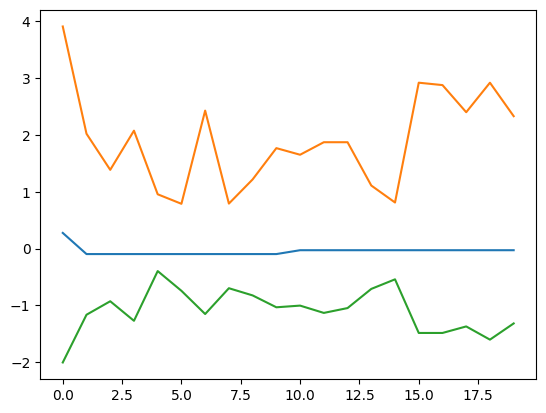

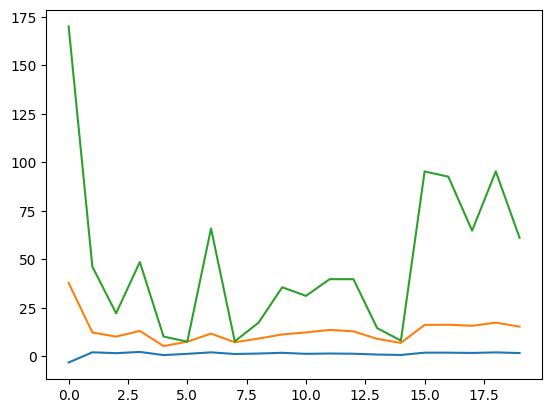

In [8]:
print(t.stack(all_actions).shape)
print(t.stack(all_payoffs).shape)
action_data = t.stack(all_actions).detach().squeeze().numpy()
payoff_data = t.stack(all_payoffs).detach().squeeze().numpy()

plt.plot(action_data)
plt.show()

plt.plot(payoff_data)
plt.show()

## Local Minimax updates

In [8]:
payoffs = []
actions = []
env = LossGame1DEnv(num_stages=3, num_players=3, d_action=1)
# for stage in range(env.num_stages):
#     env.move(t.tensor([0.3], requires_grad=True))
env = env.move(t.tensor([-0.2273], requires_grad=False))
env = env.move(t.tensor([2.36034], requires_grad=False))
env = env.move(t.tensor([-0.147711], requires_grad=False))

print(f"Initial payoff: {env.payoff.numpy()}")
print(f"Initial actions: {t.cat(env.state).numpy()}")
updater = LocalMinimaxUpdate(env, learning_rate=0.001, max_branching_factor=3)

try:
    for step in tqdm(range(1000)):
        env = updater.update()
        payoffs.append(env.payoff)
        actions.append(t.cat(env.state))
        # print(env.state)
        # print(env.payoff)
except:
    print(env.state)

payoffs = t.stack(payoffs).detach().squeeze().numpy()
actions = t.stack(actions).detach().squeeze().numpy()
print(f"Equilibrium payoff: {payoffs[-1]}")
print(f"Equilibrium actions: {actions[-1]}")


Initial payoff: [-0.13907366 -1.8648107  49.078373  ]
Initial actions: [-0.2273    2.36034  -0.147711]


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 135.36it/s]

Equilibrium payoff: [ 2.989914    0.15186453 27.718964  ]
Equilibrium actions: [-0.5392963  1.5563455 -0.9507022]


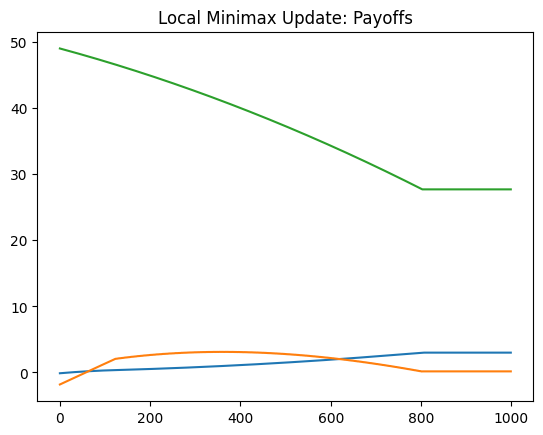

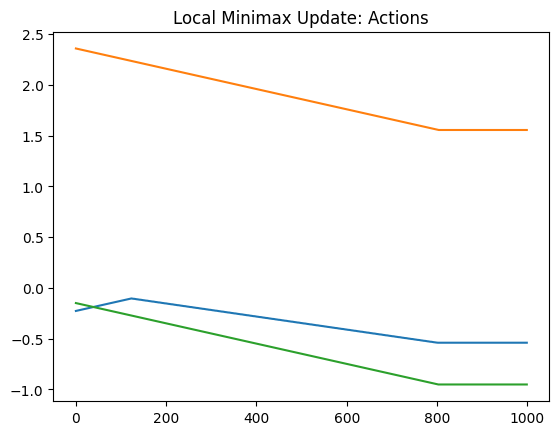

In [9]:
plt.plot(payoffs)
plt.title("Local Minimax Update: Payoffs")
plt.show()

plt.plot(actions)
plt.title("Local Minimax Update: Actions")
plt.show()

## Vanilla Gradient update

This is not guaranteed to find a SPNE. In fact it does not...

In [6]:
payoffs = []
actions = []
env = LossGame1DEnv(num_stages=3, num_players=3, d_action=1)
env = env.move(t.tensor([-0.2273], requires_grad=True))
env = env.move(t.tensor([2.36034], requires_grad=True))
env = env.move(t.tensor([-0.147711], requires_grad=True))

print(f"Initial payoff: {env.payoff.detach().numpy()}")
print(f"Initial actions: {t.cat(env.state).detach().numpy()}")

update = VanillaGradientUpdate(env, learning_rate=0.001, clip_grad_norm=1.0)

for step in tqdm(range(2000)):
    env = update.update()
    payoffs.append(env.payoff)
    actions.append(t.cat(env.state))

payoffs = t.stack(payoffs).detach().squeeze().numpy()
actions = t.stack(actions).detach().squeeze().numpy()

print(payoffs.shape)
print(actions.shape)

print(f"Equilibrium payoff: {payoffs[-1]}")
print(f"Equilibrium actions: {actions[-1]}")


Initial payoff: [-0.13907366 -1.8648107  49.078373  ]
Initial actions: [-0.2273    2.36034  -0.147711]


100%|██████████| 2000/2000 [00:04<00:00, 478.84it/s]


(2000, 3)
(2000, 3)
Equilibrium payoff: [  2. -12.  11.]
Equilibrium actions: [-1.  1. -1.]


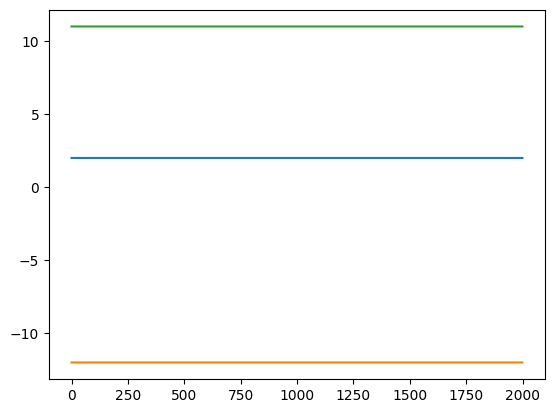

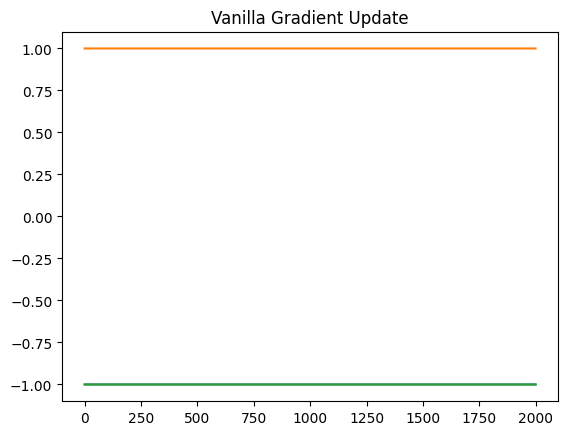

In [5]:
from matplotlib import pyplot as plt

plt.plot(payoffs)
plt.show()
plt.title("Vanilla Gradient Update")
plt.plot(actions)
plt.show()

## Testing old cMCTS code

One assumption in the `QuantumSimpleBoard()` implementation is that only the magnitudes matter...

In [4]:
import joblib

data = joblib.load("Data/quantum_board/MCTS-vgd-freq_2_00lr_1em03125522.pkl")
data

,num_simulations,action,value
0,1000,"[[tensor(-0.0002, dtype=torch.float64), tensor...","tensor(-0.0003, dtype=torch.float64)"


In [5]:
data["action"][0]

[tensor([-1.5491e-04,  4.6164e-02,  9.9806e-01,  1.0567e-02,  4.0516e-02],
        dtype=torch.float64),
 tensor([ 0.7082, -0.0125, -0.0054,  0.0135,  0.7058], dtype=torch.float64),
 tensor([-0.1974, -0.3864, -0.6749,  0.5440,  0.2457], dtype=torch.float64)]